In [11]:
import random

import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import tengp
from gpbenchmarks import get_data


def pdivide(x, y):
    return np.divide(x, y, out=np.copy(x), where=x!=0)

def plog(x, y):
    return np.log(x, out=np.copy(x), where=x>0)

def psin(x, y):
    return np.sin(x)

def pcos(x, y):
    return np.cos(x)

def pow2(x, y):
    return x**2

def pow3(x, y):
    return x**3

def ptan(x, y):
    return np.tan(x)

def ptanh(x, y):
    return np.tanh(x)

def psqrt(x, y):
    return  np.sqrt(x)

def pexp(x, y):
    return np.exp(x)


funset = tengp.FunctionSet()
funset.add(np.add, 2)
funset.add(np.subtract, 2)
funset.add(np.multiply, 2)
funset.add(pdivide, 2)
funset.add(plog, 2)
funset.add(psin, 2)
funset.add(pcos, 2)

#     function set: +, -, *, /, sin, cos, tan, tanh, sqrt, exp, log, **2, **3
ext_funset = tengp.FunctionSet()
ext_funset.add(np.add, 2)
ext_funset.add(np.subtract, 2)
ext_funset.add(np.multiply, 2)
ext_funset.add(pdivide, 2)
ext_funset.add(psin, 2)
ext_funset.add(pcos, 2)
ext_funset.add(ptan, 2)
ext_funset.add(ptanh, 2)
ext_funset.add(psqrt, 2)
ext_funset.add(pexp, 2)
ext_funset.add(plog, 2)
ext_funset.add(pow2, 2)
ext_funset.add(pow3, 2)

def sfn(c):
    return (np.sin(2 * np.pi * (c - 1/4)) + 1)/2

params1d = tengp.Parameters(2, 1, 1, 50, funset, real_valued=True, smoothing_fn=sfn)
params2d = tengp.Parameters(3, 1, 1, 50, funset, real_valued=True, smoothing_fn=sfn)
params5d = tengp.Parameters(6, 1, 1, 50, ext_funset, real_valued=True, smoothing_fn=sfn)

functions = [('nguyenf4', params1d, [20, -1, 1]), ('nguyenf7', params1d, [20, 0, 2]), ('nguyenf10', params2d, [100, -1, 1]), ('korns12', params5d, [10000, -50, 50])]

In [12]:
trials = 10

In [156]:
# def cost_function(params, bounds, y, X, G):
#     clipped = []
#     for gene, bound in zip(G, bounds):
#         if gene < 0:
#             clipped.append(0)
#         elif gene > bound:
#             clipped.append(bound)
#         else:
#             clipped.append(gene)

#     individual = tengp.individual.NPIndividual(clipped, bounds, params)
#     pred = individual.transform(X)

#     try:
#         out = mean_squared_error(pred, y)
#     except ValueError:
#         out = np.inf
#     return (out, )
def scale_a(x, a, b):
    return a + (b - a) * x / 10

def scale_b(x, a, b):
    return a + (b - a) * (x/10)**2

def scale_c(x, a, b):
    return a *(b/a)**(x/10)

import math

def bound(x, a, b):
    return a + (b - a) * ( 1 - np.cos(np.pi * x/10))/2

def cost_function(params, bounds, y, X, rv_genes):
    bounded = bound(np.array(rv_genes), 0, 10)
    scaled = [scale_b(x, max([0, b-10]), b) for x, b in zip(bounded, bounds)]
    
    individual = tengp.individual.NPIndividual(scaled, bounds, params)
    pred = individual.transform(X)
    
    try:
        out = mean_squared_error(pred, y)
    except ValueError:
        out = np.inf
    return (out, )

In [157]:
from deap import creator, base, tools, cma, algorithms
from collections import namedtuple
from array import array

In [158]:
%%time

rv_results = []

for function in functions:
    np.random.seed(42)
    print(function[0])
    trial_results = []
    for trial in range(trials):
        print(trial, end=',')
        params = function[1]
        X, y = get_data(function[0], *function[2])
        X = np.c_[np.ones(len(X)), X]
        bounds = tengp.individual.IndividualBuilder(params).create().bounds[:]

        creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
        creator.create('Individual', array, typecode='f', fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register('evaluate', cost_function, params, bounds, y, X)
        
#         parent = creator.Individual([np.random.uniform(0, 10) for b in bounds])
#         parent.fitness.values = toolbox.evaluate(parent)
        
        #strategy = cma.StrategyOnePlusLambda(parent=parent, sigma=2, lambda_=4)
        strategy = cma.Strategy(centroid=[np.random.uniform(0, 10) for b in bounds], sigma=2)

        toolbox.register("generate", strategy.generate, creator.Individual)
        toolbox.register("update", strategy.update)

        hof = tools.HallOfFame(1)
        
        res = algorithms.eaGenerateUpdate(toolbox, ngen=250, halloffame=hof, verbose=False)
        
        
        val = toolbox.evaluate(hof[0])
        print(val)
        
        trial_results.append(val)
    rv_results.append(trial_results)
    print()

nguyenf4
0,

/home/jarino/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/jarino/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


KeyboardInterrupt: 

In [145]:
t = toolbox.generate()[0]

In [151]:
bounded = bound(np.array(t), 0, 10)

In [153]:
bb = np.array([scale_b(x, 0, b) for x, b in zip(bounded, bounds)])

In [154]:
np.c_[bb,bounds]

array([[3.88333441e+00, 1.20000000e+01],
       [1.16617321e+00, 5.00000000e+00],
       [3.98757486e+00, 5.00000000e+00],
       [1.06450890e+01, 1.20000000e+01],
       [1.34305089e-01, 6.00000000e+00],
       [5.34195333e-03, 6.00000000e+00],
       [3.70557270e-05, 1.20000000e+01],
       [6.33911147e+00, 7.00000000e+00],
       [9.15412125e-01, 7.00000000e+00],
       [1.18912813e+01, 1.20000000e+01],
       [4.40450869e+00, 8.00000000e+00],
       [8.35710133e-02, 8.00000000e+00],
       [6.24693057e+00, 1.20000000e+01],
       [3.50033512e-03, 9.00000000e+00],
       [8.89245122e+00, 9.00000000e+00],
       [2.52025919e+00, 1.20000000e+01],
       [2.23389056e+00, 1.00000000e+01],
       [3.66357320e+00, 1.00000000e+01],
       [3.10983653e-03, 1.20000000e+01],
       [2.88537740e-01, 1.10000000e+01],
       [1.66246706e+00, 1.10000000e+01],
       [1.46144906e+00, 1.20000000e+01],
       [5.92374341e-01, 1.20000000e+01],
       [4.79843324e+00, 1.20000000e+01],
       [4.006790

In [100]:
c = toolbox.update(i)

In [101]:
c

In [65]:
def plot_results(outs):
    costs = np.array(outs)
    print('mean:', np.mean(costs))
    print('median:', np.median(costs))
    print('variance:',np.var(costs))
    print('min:', np.min(costs))
    sns.distplot(costs);

Nguyen4
mean: 0.5285101406977919
median: 0.4183817170678142
variance: 0.09326328253328724
min: 0.20161383681627815


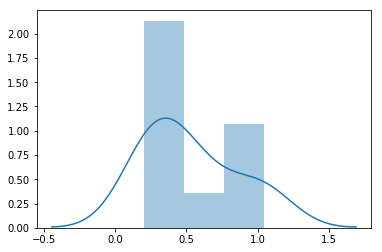

In [66]:
print('Nguyen4')
plot_results([x[0] for x in rv_results[0]])

Nguyen7
mean: 0.028908218592275586
median: 0.00451780748056445
variance: 0.0033634480612051384
min: 0.0010923017384734887


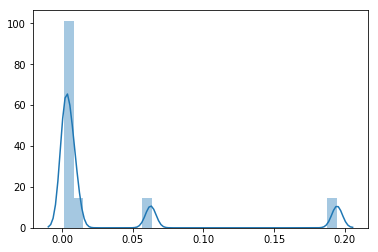

In [67]:
print('Nguyen7')
plot_results([x[0] for x in rv_results[1]])

Nguyen10
mean: 0.0550873073246657
median: 0.05664908275304502
variance: 2.846582129606875e-05
min: 0.03911951824957429


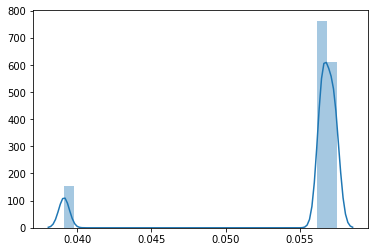

In [68]:
print('Nguyen10')
plot_results([x[0] for x in rv_results[2]])

Korns12
mean: 2.321134298288013
median: 2.3211342982748384
variance: 1.1175062628219103e-21
min: 2.3211342982742846


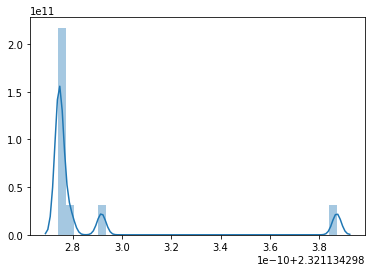

In [69]:
print('Korns12')
plot_results([x[0] for x in rv_results[3]])